# **Prova II - Inteligência Artificial**

##  **Bibliotecas Necesárias**

In [470]:
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn

In [471]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## **Dados utilizados**

In [472]:
df = pd.read_csv('akc-data-latest.csv')
df.head()
print(df.columns)

Index(['Unnamed: 0', 'description', 'temperament', 'popularity', 'min_height',
       'max_height', 'min_weight', 'max_weight', 'min_expectancy',
       'max_expectancy', 'group', 'grooming_frequency_value',
       'grooming_frequency_category', 'shedding_value', 'shedding_category',
       'energy_level_value', 'energy_level_category', 'trainability_value',
       'trainability_category', 'demeanor_value', 'demeanor_category'],
      dtype='object')


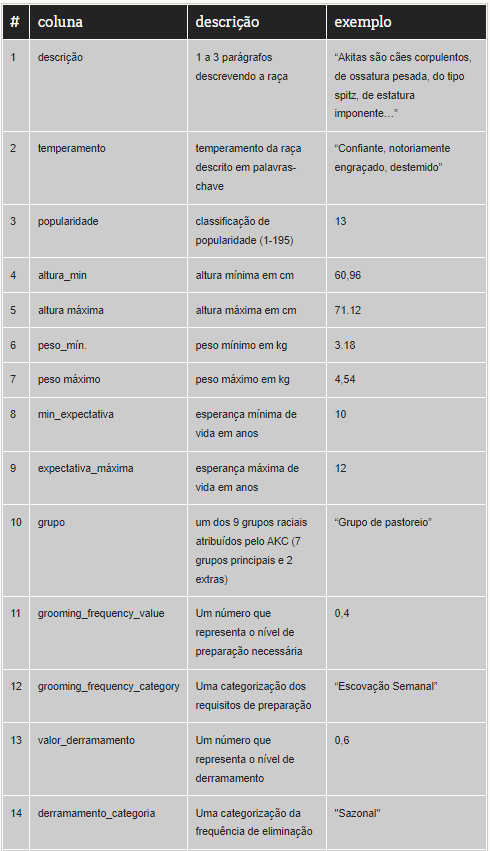


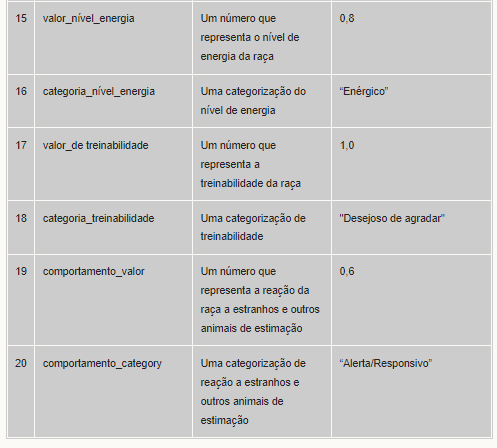

In [473]:
# A classificação de comportamento do animal na presença de estranhos será o objetivo
print(df['demeanor_category'].unique())

['Outgoing' 'Aloof/Wary' 'Friendly' 'Alert/Responsive' nan
 'Reserved with Strangers']


## **Preparação dos dados**
Para que seja possível utilizar um modelo de classificação é necessário que os dados sejam tratados e preparados.

### **Removendo colunas desnecessárias**

In [474]:
# Removendo instancias repetidas
df = df.drop_duplicates()

# A descrição do anival não será utilizada
df = df.drop(columns=['description']) 
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['demeanor_value']) # O target será o demeanor_category, e não o demeanor_value (por escolha).

# Foram testadas as remoções das colunas abaixo, mas a acurácia e F1 Score dos modelos diminuiram.
# Logo, será removida apenas a coluna 'description' e 'demeanor_value' (por ser uma 'segunda label' do target).

# df = df.drop(columns=['temperament'])
# df = df.drop(columns=['shedding_value'])
# df = df.drop(columns=['shedding_category'])
# df = df = df.drop(columns=['grooming_frequency_category'])
# df = df.drop(columns=['trainability_category'])
# df = df.drop(columns=['min_expectancy'])
# df = df.drop(columns=['max_expectancy'])




### **Removendo instancias que possuem valores nulos e duplicatas**

In [475]:
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(188, 18)


,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_category
0,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,Outgoing
1,"Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,Aloof/Wary
2,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,Friendly
3,"Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,Alert/Responsive
4,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,Friendly


### **normalizando os dados**

In [476]:
# Todos os valores de popularidade que não estiverem entre 1 e 195 serão removidos (removendo casos como 'Of')
list_1_to_195 = list(range(1, 196))

list_1_to_195 = [str(i) for i in list_1_to_195]
df = df[df['popularity'].isin(list_1_to_195)]

# Normalizando popularidade de 1-195 para 0-1
df['popularity'] = df['popularity'].astype(int) / 195
df.head()

,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_category
0,"Confident, Famously Funny, Fearless",0.758974,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,Outgoing
1,"Dignified, Profoundly Loyal, Aristocratic",0.579487,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,Aloof/Wary
2,"Friendly, Clever, Courageous",0.307692,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,Friendly
3,"Courageous, Dignified, Profoundly Loyal",0.241026,60.96,71.12,31.751466,58.967008,10.0,13.0,Working Group,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,Alert/Responsive
4,"Affectionate, Loyal, Playful",0.297436,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,Friendly


In [477]:
# Transforma cada classe em um número
for column in df.columns:
    if df[column].dtype == type(str):
        df[column] = le.fit_transform(df[column])

df.head()

,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_category
0,60,0.758974,22.86,29.21,3.175147,4.535924,12.0,15.0,5,0.6,0,0.6,4,0.6,4,0.8,2,3
1,77,0.579487,63.50,68.58,22.679619,27.215542,12.0,15.0,1,0.8,1,0.2,1,0.8,2,0.2,4,1
2,97,0.307692,58.42,58.42,22.679619,31.751466,11.0,14.0,4,0.6,0,0.4,2,0.6,4,1.0,1,2
3,72,0.241026,60.96,71.12,31.751466,58.967008,10.0,13.0,6,0.8,1,0.6,4,0.8,2,1.0,1,0
4,25,0.297436,58.42,63.50,34.019428,38.555351,10.0,14.0,6,0.6,0,0.6,4,0.8,2,0.4,3,2


### **Seleção de atributos mais relevantes**

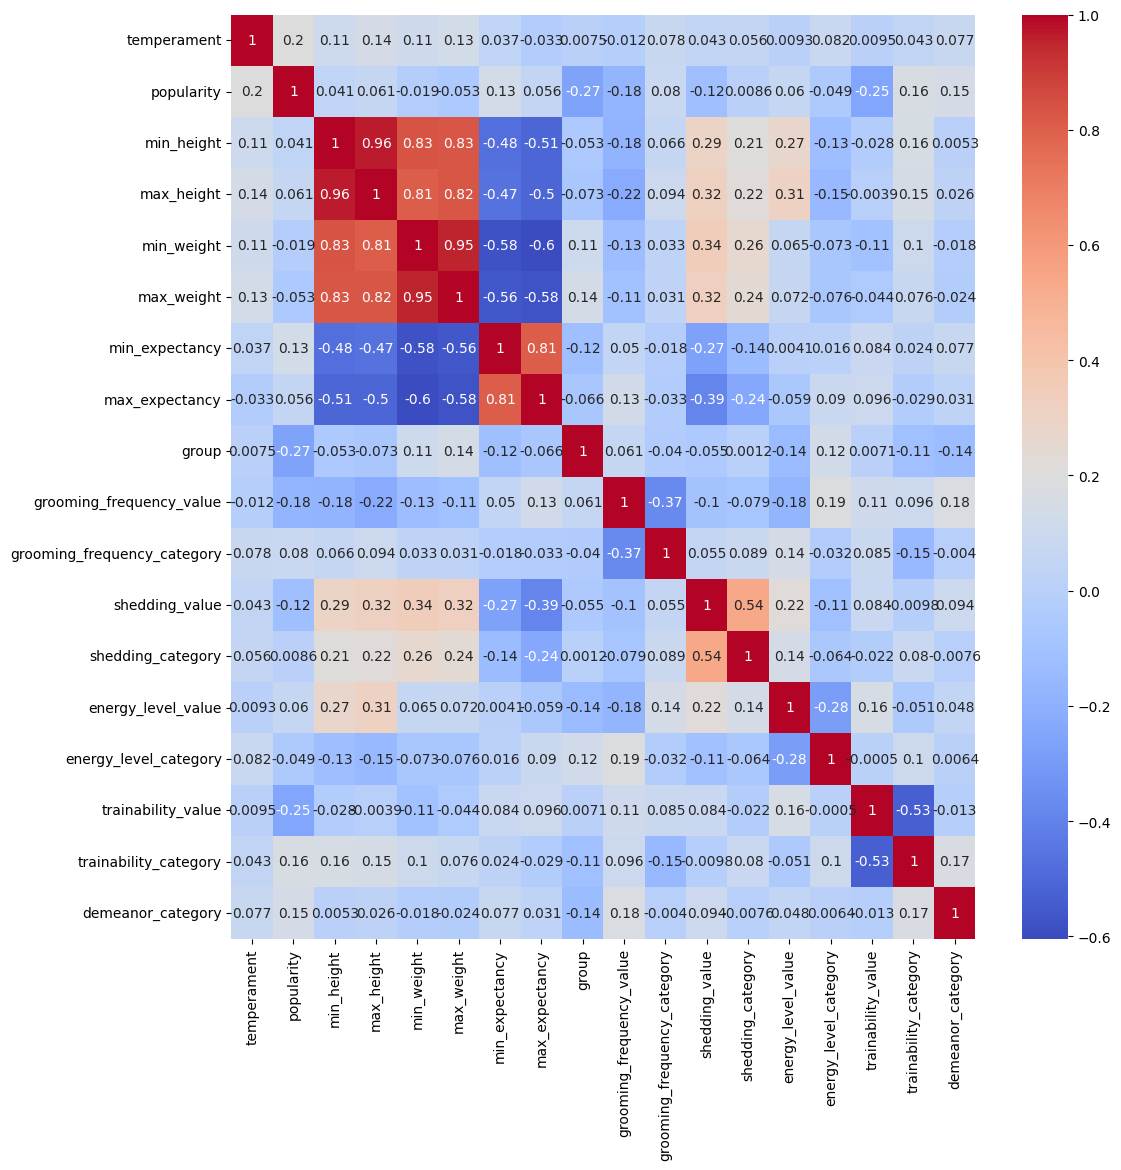

In [478]:
# Verificando correlação de atributos
correlation = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()


As melhores métricas foram obtidas utilizando a remoção abaixo. Para testar com todos os atributos, basta comentar a célula abaixo.

In [479]:
# Todos os atributos que possuem alta correlação entre si serão removidos
correlation = df.corr()
correlation = correlation.abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)] # 0.7 é um valor arbitrário
df = df.drop(columns=to_drop)
df.head()

# Aplicando PCA para reduzir a dimensionalidade
## UPDATE: Não foi utilizado PCA, pois a acurácia e F1 Score dos modelos diminuiram (testado com n_components=2, 3 e 4).
# from sklearn.decomposition import PCA
# pca = PCA(n_components=4)
# pca_result = pca.fit_transform(df)
# pca_result = pd.DataFrame(pca_result, columns=['pca1', 'pca2', 'pca3', 'pca4'])
# pca_result['demeanor_category'] = df['demeanor_category']
# pca_result.head()
# df = pca_result

,temperament,popularity,min_height,min_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_category
0,60,0.758974,22.86,12.0,5,0.6,0,0.6,4,0.6,4,0.8,2,3
1,77,0.579487,63.50,12.0,1,0.8,1,0.2,1,0.8,2,0.2,4,1
2,97,0.307692,58.42,11.0,4,0.6,0,0.4,2,0.6,4,1.0,1,2
3,72,0.241026,60.96,10.0,6,0.8,1,0.6,4,0.8,2,1.0,1,0
4,25,0.297436,58.42,10.0,6,0.6,0,0.6,4,0.8,2,0.4,3,2


### **Balanceando os dados**

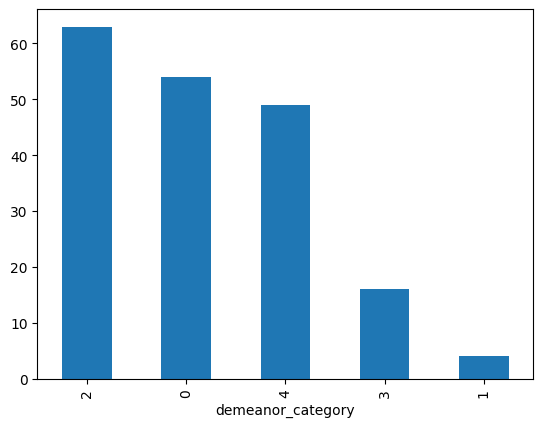

demeanor_category
2    63
0    54
4    49
3    16
1     4
Name: count, dtype: int64


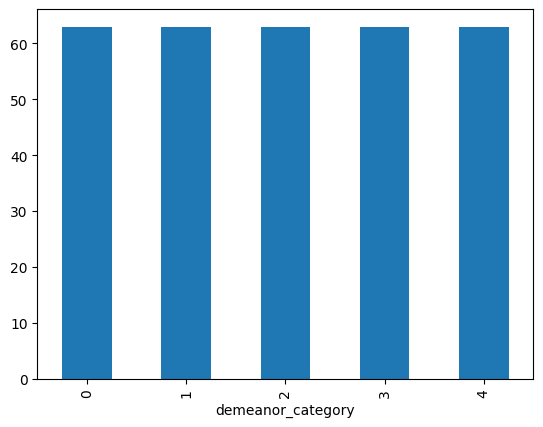

demeanor_category
0    63
1    63
2    63
3    63
4    63
Name: count, dtype: int64


In [480]:
# Visualização do balanceamento atual
df['demeanor_category'].value_counts().plot(kind='bar')
plt.show()
print(df['demeanor_category'].value_counts())

# Balanceamento das classes com oversampling
from sklearn.utils import resample

df_0 = df[df['demeanor_category'] == 0]
df_1 = df[df['demeanor_category'] == 1]
df_2 = df[df['demeanor_category'] == 2]
df_3 = df[df['demeanor_category'] == 3]
df_4 = df[df['demeanor_category'] == 4]


# df_2 é a classe majoritária, então os outros serão aumentados para o tamanho de df_2.
df_0 = resample(df_0, replace=True, n_samples=len(df_2), random_state=42)
df_1 = resample(df_1, replace=True, n_samples=len(df_2), random_state=42)
df_3 = resample(df_3, replace=True, n_samples=len(df_2), random_state=42)
df_4 = resample(df_4, replace=True, n_samples=len(df_2), random_state=42)
df = pd.concat([df_0, df_1, df_2, df_3, df_4])

df['demeanor_category'].value_counts().plot(kind='bar')
plt.show()
print(df['demeanor_category'].value_counts())




## **Aprendizagem supervisionada**


In [481]:
def show_confusion_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### **Split**

In [482]:
# validação cruzada estratificada 10-fold
skf = StratifiedKFold(n_splits=10)
X = df.drop(columns=['demeanor_category'])
y = df['demeanor_category']

### **Árvore de decisão**

Decision Tree Accuracy:  0.8157258064516129
Decision Tree F1 Score:  0.8068938319744771


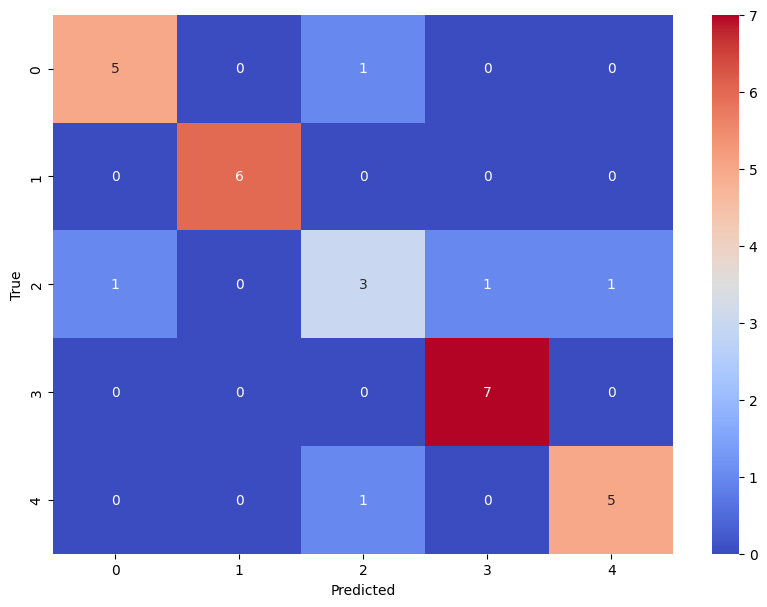

In [483]:
# Árvore de Decisão
accuracy = []
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    
print("Decision Tree Accuracy: ", np.mean(accuracy))
print("Decision Tree F1 Score: ", np.mean(f1_scores))
show_confusion_matrix(y_test, y_pred)

### **Random Forest**

Random Forest Accuracy:  0.8196572580645162
Random Forest F1 Score:  0.8144064112410886


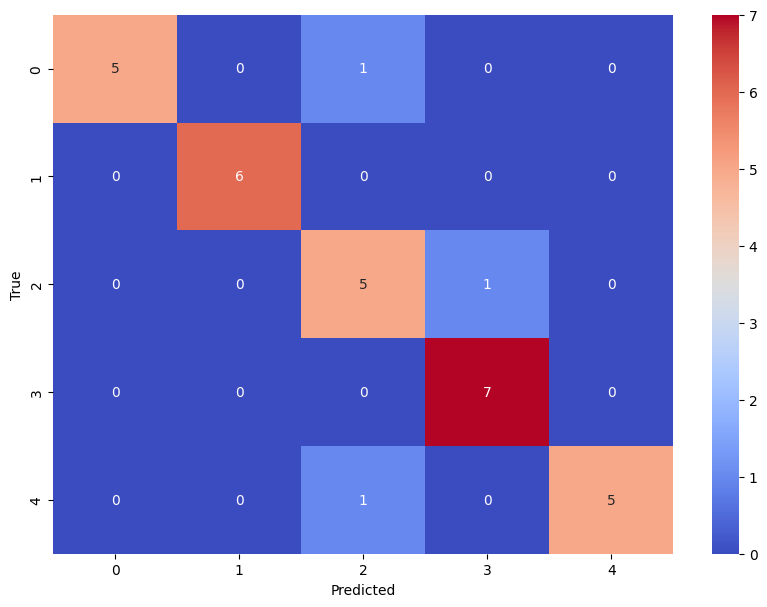

In [484]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
accuracy = []
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

print("Random Forest Accuracy: ", np.mean(accuracy))
print("Random Forest F1 Score: ", np.mean(f1_scores))
show_confusion_matrix(y_test, y_pred)

### **Naiive Bayes**

Naive Bayes Accuracy:  0.5078629032258064
Naive Bayes F1 Score:  0.49809240599296345


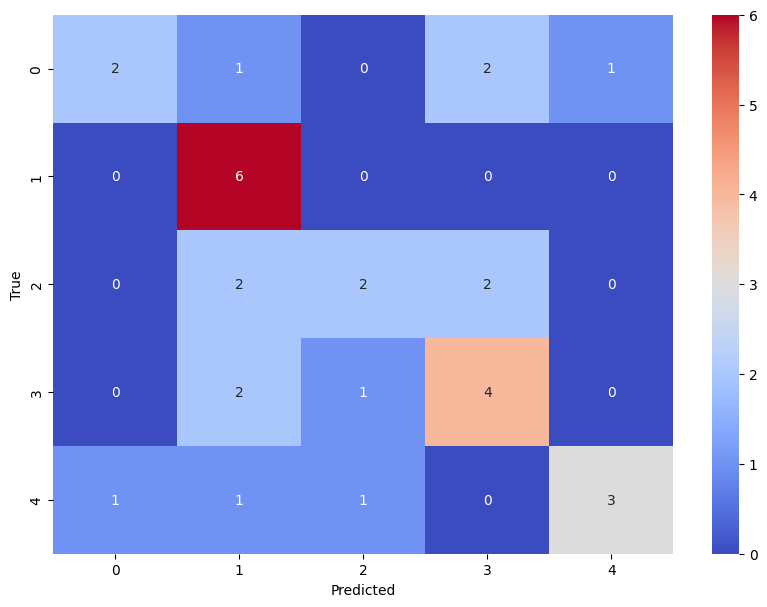

In [485]:
# Naive Bayes
accuracy = []
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
print("Naive Bayes Accuracy: ", np.mean(accuracy))
print("Naive Bayes F1 Score: ", np.mean(f1_scores))
show_confusion_matrix(y_test, y_pred)


### **MLP**

MLP Accuracy:  0.666733870967742
MLP F1 Score:  0.658865962666366


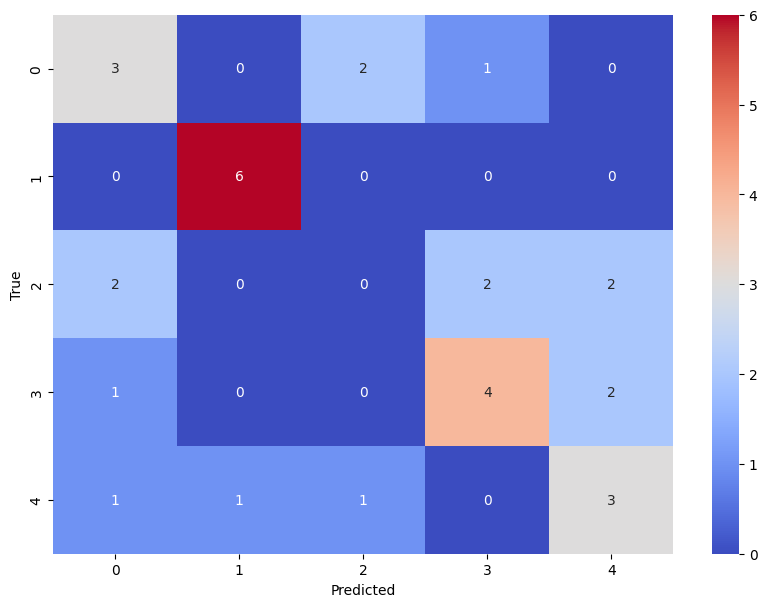

In [486]:
accuracy = []
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train) # Max iter setado para 1000 pois o default (200) não foi suficiente para convergir.
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

print("MLP Accuracy: ", np.mean(accuracy))
print("MLP F1 Score: ", np.mean(f1_scores))
show_confusion_matrix(y_test, y_pred)

## **Não-supervisionado**

In [487]:
# Retirando o atributo 'demeanor_category', pois ele é o target
features = df.drop(columns=['demeanor_category'])

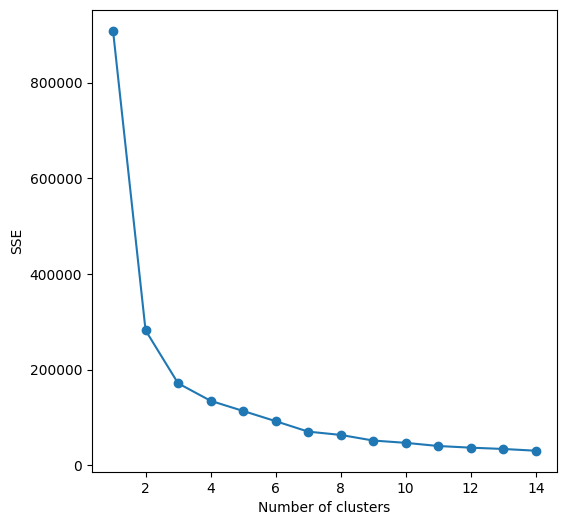

In [488]:
# K-means e visualização 
from sklearn.cluster import KMeans

# Visualização dos clusters com TSNE
from sklearn.manifold import TSNE

sse = []

# Testando K de 1 a 10
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

# Plot do gráfico do cotovelo
plt.figure(figsize=(6, 6))
plt.plot(range(1, 15), sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()



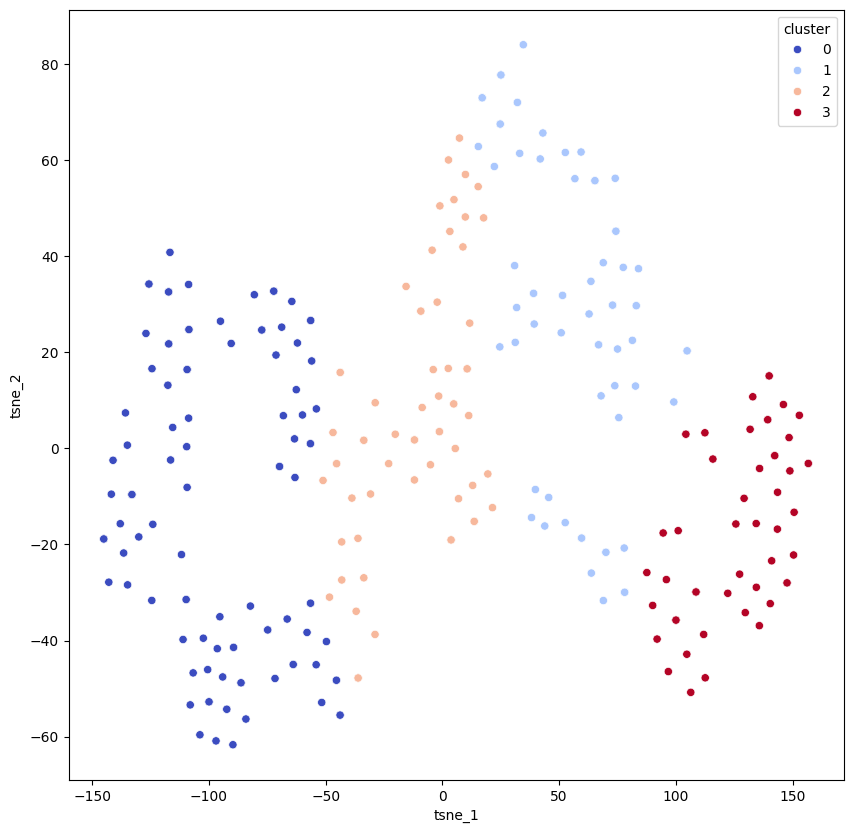

In [489]:
# Uma vez escolhido o K = 4, vamos visualizar os clusters com TSNE
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features)
df['cluster'] = kmeans.labels_

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(features)
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette='coolwarm')
plt.show()


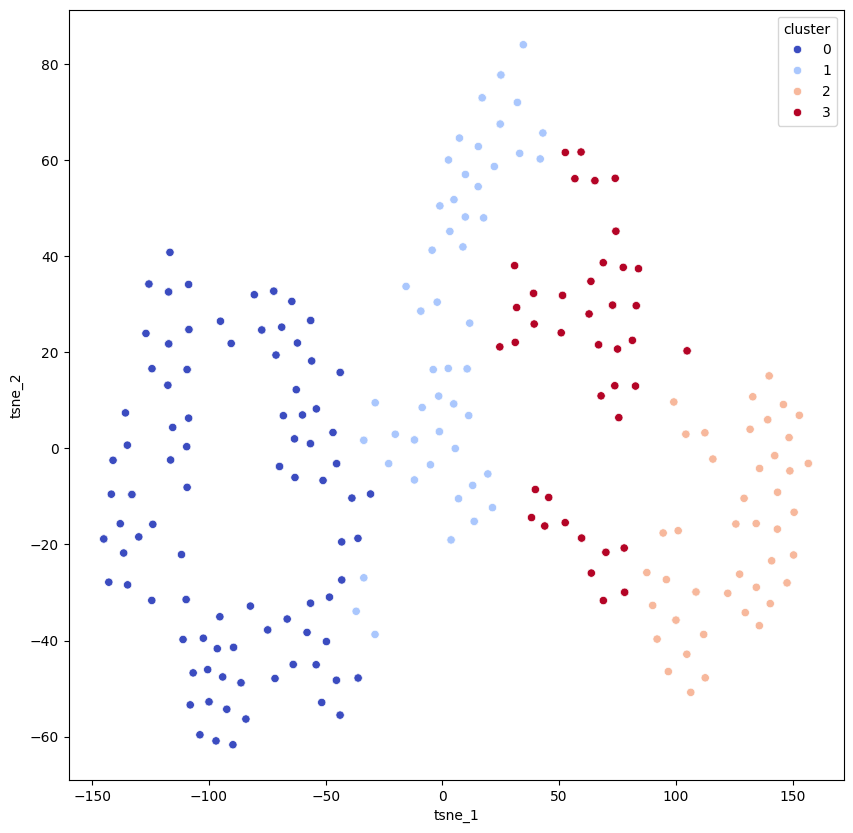

In [490]:
# Método Hierárquico com o valor de K do K-means (obtido pelo método do cotovelo)
agg = AgglomerativeClustering(n_clusters=k)
df['cluster'] = agg.fit_predict(features)

plt.figure(figsize=(10, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette='coolwarm')
plt.show()

In [491]:

# Comparando hierárquico com K-means (sendo K = 4, o do método do cotovelo)
print("K-means silhouette score: ", silhouette_score(features, kmeans.labels_))
print("Hierarchical silhouette score: ", silhouette_score(features, agg.labels_))
if silhouette_score(features, kmeans.labels_) > silhouette_score(features, agg.labels_):
    print(f"K-means {k} é melhor.")
else:
    print(f"Hierarchical {k} é melhor.")



K-means silhouette score:  0.3998635853592624
Hierarchical silhouette score:  0.39632008702312915
K-means 4 é melhor.


In [492]:
# Agora variando o linkage no método hierárquico com o mesmo valor de K do método do cotovelo (4)
agg = AgglomerativeClustering(n_clusters=k)

# Realizar o agrupamento com linkage 'ward'
agg_ward = agg.fit(X) # default é 'ward'
agg_ward_silhouette_score = silhouette_score(X, agg_ward.labels_)

# Realizar o agrupamento com linkage 'complete'
agg_complete = agg.set_params(linkage='complete').fit(X)
agg_complete_silhouette_score = silhouette_score(X, agg_complete.labels_)

# Realizar o agrupamento com linkage 'average'
agg_average = agg.set_params(linkage='average').fit(X)
agg_average_silhouette_score = silhouette_score(X, agg_average.labels_)

# Realizar o agrupamento com linkage 'single'
agg_single = agg.set_params(linkage='single').fit(X)
agg_single_silhouette_score = silhouette_score(X, agg_single.labels_)

scores = [agg_ward_silhouette_score, agg_complete_silhouette_score, agg_average_silhouette_score, agg_single_silhouette_score]
best_score = max(scores)
best_linkage = ['ward', 'complete', 'average', 'single'][scores.index(best_score)]
print("Hierarchical silhouette score (ward): ", silhouette_score(X, agg_ward.labels_))
print("Hierarchical silhouette score (complete): ", agg_complete_silhouette_score)
print("Hierarchical silhouette score (average): ", agg_average_silhouette_score)
print("Hierarchical silhouette score (single): ", agg_single_silhouette_score)
print(f"\nO melhor linkage é {best_linkage} com um silhouette score de {best_score}")

print(f"Considerando o silhouette score do K-means como sendo {silhouette_score(features, kmeans.labels_)}")
if silhouette_score(features, kmeans.labels_) > best_score:
    print(f"K-means {k} tem um melhor silhouette score.")
else:
    print(f"\nHierarchical {k} com linkage {best_linkage} tem um melhor silhouette score.")

Hierarchical silhouette score (ward):  -0.3078327298974365
Hierarchical silhouette score (complete):  0.37646965181000125
Hierarchical silhouette score (average):  0.40647093431298775
Hierarchical silhouette score (single):  -0.3078327298974365

O melhor linkage é average com um silhouette score de 0.40647093431298775
Considerando o silhouette score do K-means como sendo 0.3998635853592624

Hierarchical 4 com linkage average tem um melhor silhouette score.


## **Conclusões**

*Em relação aos métodos de aprendizagem não supervisionada, o KMeans foi o que obteve melhores resultados de silhueta, com K=4; entranto, todas as metodologias em relação ao label original, considerando o adjusted_rand_score, não foram capazes de obter resultados satisfatórios.
Isto é explicável pelo fato de que os dados não são linearmente separáveis, o que dificulta a classificação dos mesmos; isto pode ser observado pelo gráfico abaixo; a disparsão dos dados é muito grande, o que dificulta a classificação dos mesmos.*

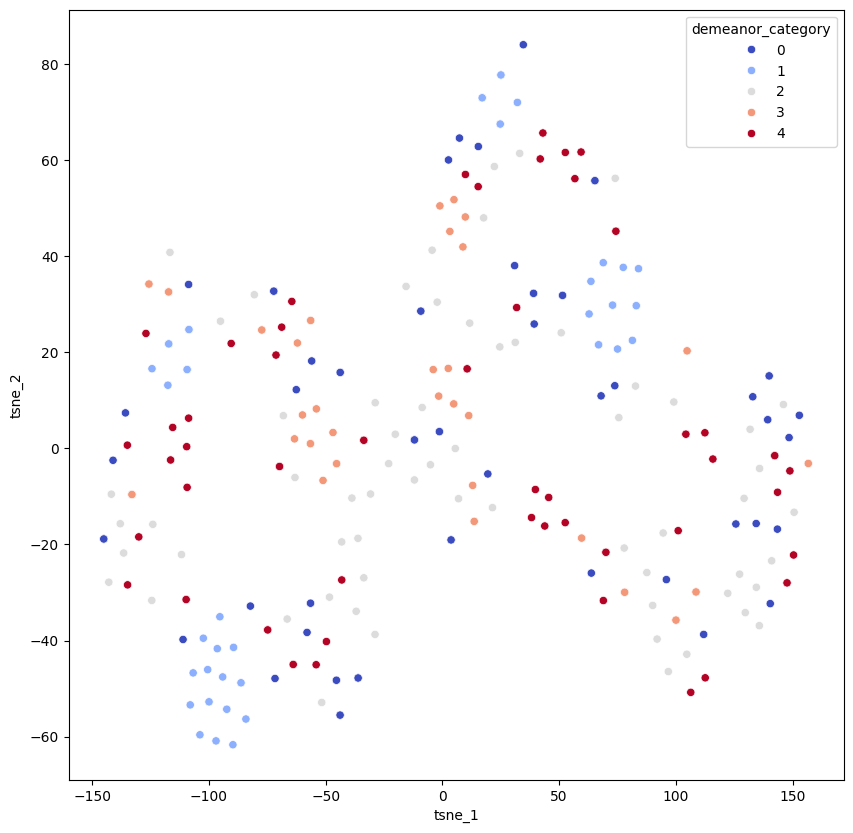

In [493]:
# Verificando a distribuição de demeanor_category com TSNE
plt.figure(figsize=(10, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='demeanor_category', data=df, palette='coolwarm')
plt.show()

*Os resultados obtidos com as metodologias de aprendizagem supervisionada foram satisfatórios, com destaque para o Random Forest, que obteve o melhor F1 Score (**0.8144064112410886**), seguido pela Árvore de Decisão, com resultados próximos. Para este trabalho o processo de pré-processamento dos dados foi fundamental para a obtenção de resultados satisfatórios, cada etapa impactou significamente nas métricas obtidas, principalmente a remoção de atributos com alta correlação entre si.*
*O balanceamento dos dados também foi fundamental para a obtenção de resultados satisfatórios, sem o balanceamento, os resultados obtidos foram muito inferiores.*

*Foram testadas outras técninas para melhorar os resultados, como a remoção de colunas que 'não faziam sentido' para o problema e utilização de PCA (para redução de dimensionalidade), por exemplo. Entretanto, estas técnicas não foram capazes de melhorar os resultados obtidos, pelo contrário, pioraram os resultados obtidos; por estes problemas, as mesmas não foram utilizadas - ficando apenas comentadas no código.*


*Para todos os resultados obtidos, é notório o impacto da baixa quantidade de dados. Por haver poucas instâncias de cada classe, principalmente para as classes 1 e 2, os erros de predição são esperados (ainda que tenha sido feito o oversampling).*


*Todavia, é possível considerar que os resultados obtidos foram satisfatórios, considerando a complexidade do problema e a quantidade de dados disponíveis.*